In [17]:
import pandas as pd
df = pd.read_csv('final_merged_data.csv')

## Check Multicollinearity

--- Variance Inflation Factor (VIF) ---
          Variable        VIF
0   Sentiment_Lag1   1.220449
1    Log_Buzz_Lag1   1.085016
2  Return_Abs_Lag1   1.774356
3  Volatility_Lag1   1.973035
4     RiskAppetite   1.280658
5         Fed_Rate   1.123966
6     unemployment   1.285483
7             FOMC   1.005469
8        intercept  52.226028


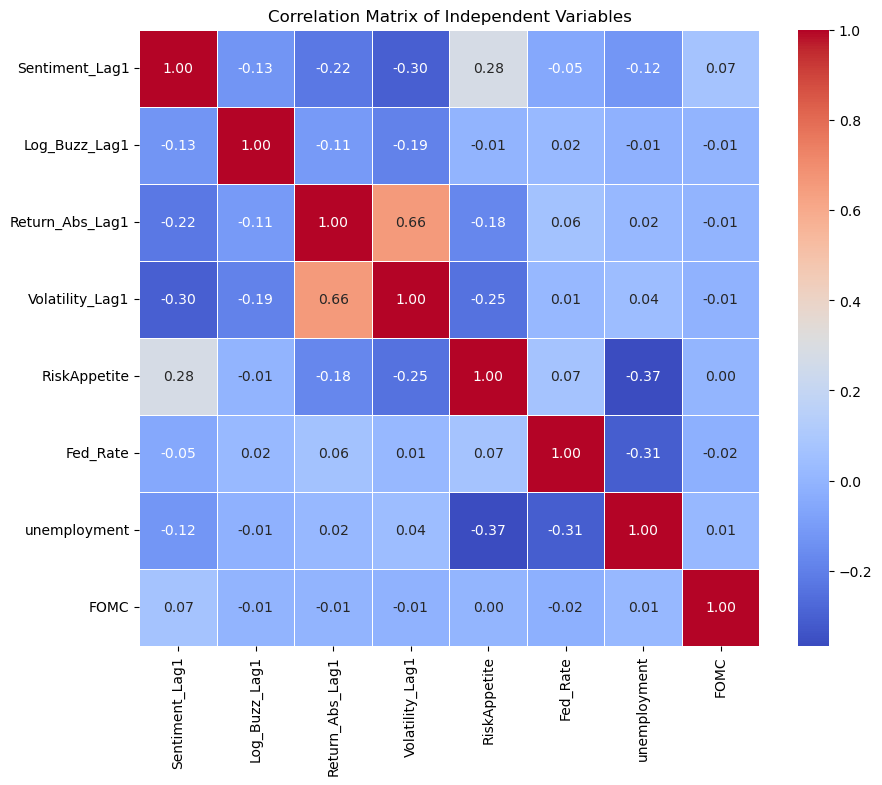

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define your independent variable list (excluding dependent variable Log_Volume)
features = ['Sentiment_Lag1', 'Log_Buzz_Lag1', 'Return_Abs_Lag1', 
            'Volatility_Lag1', 'RiskAppetite', 'Fed_Rate', 'unemployment', 'FOMC']

# Prepare data: VIF cannot handle missing values
X = df[features].dropna()
# Add intercept (required step for VIF calculation)
X['intercept'] = 1

# --- A. Calculate VIF table ---
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print("--- Variance Inflation Factor (VIF) ---")
print(vif_data)

# --- B. Plot correlation coefficient heatmap ---
plt.figure(figsize=(10, 8))
# Calculate correlation matrix
corr_matrix = df[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Independent Variables')
plt.show()

The correlation matrix shows that correlations between predictors are generally low, with the highest being 0.66 between Volatility and Absolute Return. This confirms that multicollinearity is not a major concern.

## Run the model

In [19]:
!pip install linearmodels

In [20]:
# If linearmodels is not installed, run first: !pip install linearmodels
from linearmodels.panel import PanelOLS
import pandas as pd

# ==========================================
# Step 1: Prepare panel data index
# ==========================================
# PanelOLS requires index to be in [entity, time] format
# df_final is the final table generated from the previous data cleaning step
df['date'] = pd.to_datetime(df['date'])
df_reg = df.set_index(['stock_name', 'date'])

# ==========================================
# Step 2: Define regression formula
# ==========================================
# Explanation:
# Log_Volume      : Dependent variable (Y)
# 1               : Intercept
# Sentiment_Lag1  : Core variable 1 (retail sentiment)
# Log_Buzz_Lag1   : Core variable 2 (discussion buzz/news attention)
# Return_Abs_Lag1 : Control variable (previous day's absolute return - attracts attention)
# Volatility_Lag1 : Control variable (previous day's volatility - opinion divergence)
# RiskAppetite    : Macro control (market risk appetite)
# Fed_Rate        : Macro control (interest rate environment)
# unemployment    : Macro control (economic fundamentals)
# FOMC            : Event control (Fed meeting days)
# EntityEffects   : Entity fixed effects (controls for inherent trading volume differences between AAPL and AMZN)

formula = """
Log_Volume ~ 1 + 
             Sentiment_Lag1 + 
             Log_Buzz_Lag1 + 
             Return_Abs_Lag1 + 
             Volatility_Lag1 + 
             RiskAppetite + 
             Fed_Rate + 
             unemployment + 
             FOMC + 
             EntityEffects
"""

# ==========================================
# Step 3: Run the model
# ==========================================
# drop_absorbed=True: Automatically drop macro variables that are fully absorbed by fixed effects (avoids errors)
mod = PanelOLS.from_formula(formula, data=df_reg, drop_absorbed=True)

# Use 'clustered' standard errors (clustered by Entity)
# This prevents serial correlation within the same stock from inflating P-values, making results more robust
res = mod.fit(cov_type='clustered', cluster_entity=True)

# ==========================================
# Step 4: View results
# ==========================================
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:             Log_Volume   R-squared:                        0.4091
Estimator:                   PanelOLS   R-squared (Between):             -0.1720
No. Observations:                2705   R-squared (Within):               0.4091
Date:                Wed, Dec 03 2025   R-squared (Overall):             -0.0528
Time:                        00:30:43   Log-likelihood                   -1168.0
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      232.97
Entities:                           5   P-value                           0.0000
Avg Obs:                       541.00   Distribution:                  F(8,2692)
Min Obs:                       541.00                                           
Max Obs:                       541.00   F-statistic (robust):         -6.571e+16
                            

## Check Heteroskedasticity

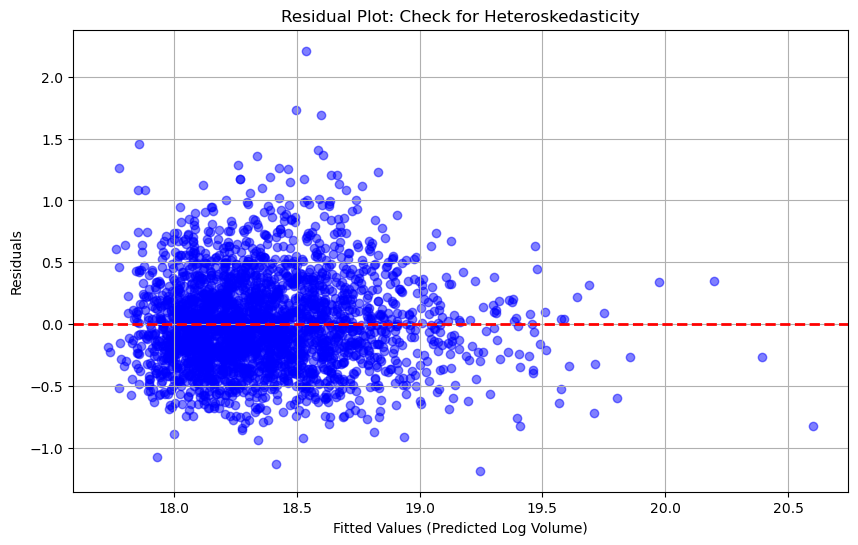

In [21]:
# Get fitted values and residuals
fitted_vals = res.fitted_values
residuals = res.resids

plt.figure(figsize=(10, 6))
plt.scatter(fitted_vals, residuals, alpha=0.5, color='blue')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Fitted Values (Predicted Log Volume)')
plt.ylabel('Residuals')
plt.title('Residual Plot: Check for Heteroskedasticity')
plt.grid(True)
plt.show()

The residual plot reveals a "fanning out" pattern, indicating the presence of heteroskedasticity. To correct for this, we utilized Clustered Standard Errors (clustered by entity).

## Check Serial Correlation

Durbin-Watson Statistic: 1.1679286249678207


<Figure size 1000x600 with 0 Axes>

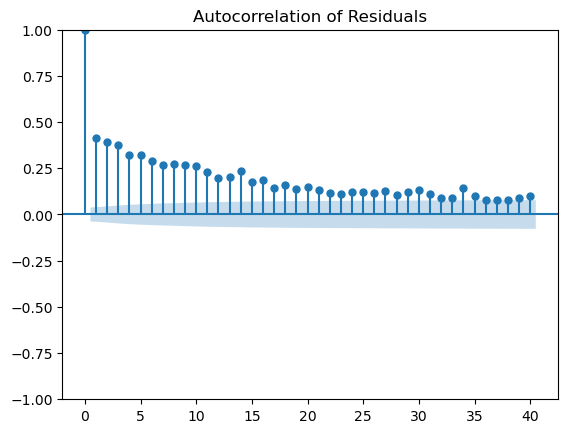

In [22]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# 1. Check Durbin-Watson statistic directly
# The linearmodels summary typically includes Durbin-Watson
print("Durbin-Watson Statistic:", sm.stats.durbin_watson(residuals))

# 2. Plot autocorrelation function (ACF Plot)
plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=40, title='Autocorrelation of Residuals')
plt.show()

The ACF plot of residuals indicates positive serial correlation (significant lags up to ~15). Our use of cluster-robust standard errors accounts for this temporal dependence within each stock's time series.